In [1]:
import os

import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler
import torchvision
import torchvision.utils as utils
import torchvision.transforms as transforms

from PIL import ImageStat

from torch.utils.tensorboard import SummaryWriter

from attn_vgg import AttnVGG
from cub2011 import Cub2011

In [2]:
im_size = 64
transform_train = transforms.Compose([
    transforms.Resize((im_size, im_size)),
    transforms.ToTensor(),
    transforms.Normalize((0.5071, 0.4867, 0.4408), (0.2675, 0.2565, 0.2761))
])
transform_test = transforms.Compose([
    transforms.Resize((im_size, im_size)),
    transforms.ToTensor(),
    transforms.Normalize((0.5071, 0.4867, 0.4408), (0.2675, 0.2565, 0.2761))
])

train_set = Cub2011(root='../../data', train=True, download=False, transform=transform_train)
train_loader = torch.utils.data.DataLoader(train_set, batch_size=16, shuffle=True, num_workers=0)
test_set = Cub2011(root='../../data', train=False, download=False, transform=transform_test)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=16, shuffle=False, num_workers=0)

In [3]:
def denormalize(img):
  imagenet_stats = np.array([[0.5071, 0.4867, 0.4408], [0.2675, 0.2565, 0.2761]])
  return img*imagenet_stats[1] + imagenet_stats[0]

def show_image(img):
  img = img.numpy().transpose(1,2,0)
  img= denormalize(img)
  plt.imshow(img)

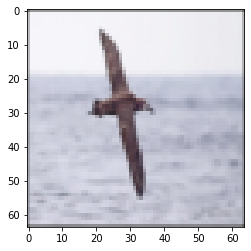

In [4]:
show_image(next(iter(train_set))[0])

In [5]:
checkpoint = torch.load('./checkpoints/attn-net_epoch_90.pth')
pretrained_dict = checkpoint['model_state_dict']
for k,v in pretrained_dict.items():
    print(k)

conv_block1.op.0.weight
conv_block1.op.0.bias
conv_block1.op.1.weight
conv_block1.op.1.bias
conv_block1.op.1.running_mean
conv_block1.op.1.running_var
conv_block1.op.1.num_batches_tracked
conv_block1.op.3.weight
conv_block1.op.3.bias
conv_block1.op.4.weight
conv_block1.op.4.bias
conv_block1.op.4.running_mean
conv_block1.op.4.running_var
conv_block1.op.4.num_batches_tracked
conv_block2.op.0.weight
conv_block2.op.0.bias
conv_block2.op.1.weight
conv_block2.op.1.bias
conv_block2.op.1.running_mean
conv_block2.op.1.running_var
conv_block2.op.1.num_batches_tracked
conv_block2.op.3.weight
conv_block2.op.3.bias
conv_block2.op.4.weight
conv_block2.op.4.bias
conv_block2.op.4.running_mean
conv_block2.op.4.running_var
conv_block2.op.4.num_batches_tracked
conv_block3.op.0.weight
conv_block3.op.0.bias
conv_block3.op.1.weight
conv_block3.op.1.bias
conv_block3.op.1.running_mean
conv_block3.op.1.running_var
conv_block3.op.1.num_batches_tracked
conv_block3.op.3.weight
conv_block3.op.3.bias
conv_block3.op

In [18]:
torch.cuda.empty_cache()

In [6]:
def filter_layer_name(filter_names, layer_name):
    for name in filter_names:
        if name in layer_name:
            return False
    return True

In [26]:
attempt = 9

In [27]:
model = AttnVGG(im_size=im_size, num_classes=200, normalize_attn=False)

# Load the last CIFAR-100 checkpoint. Note we filter out the layers that have different dimensions
filter_names = ['dense', 'classify']#, 'attn', 'projector']
pretrained_dict = {k: v for k, v in pretrained_dict.items() if filter_layer_name(filter_names, k)}

model.load_state_dict(pretrained_dict, strict=False)

_IncompatibleKeys(missing_keys=['dense.weight', 'dense.bias', 'classify.weight', 'classify.bias'], unexpected_keys=[])

In [28]:
for name, param in model.named_parameters():
    if filter_layer_name(filter_names, name):
    # if filter_layer_name(filter_names + ['attn', 'projector'], name):
        param.requires_grad = False
        print('Freezing ' + name)

Freezing conv_block1.op.0.weight
Freezing conv_block1.op.0.bias
Freezing conv_block1.op.1.weight
Freezing conv_block1.op.1.bias
Freezing conv_block1.op.3.weight
Freezing conv_block1.op.3.bias
Freezing conv_block1.op.4.weight
Freezing conv_block1.op.4.bias
Freezing conv_block2.op.0.weight
Freezing conv_block2.op.0.bias
Freezing conv_block2.op.1.weight
Freezing conv_block2.op.1.bias
Freezing conv_block2.op.3.weight
Freezing conv_block2.op.3.bias
Freezing conv_block2.op.4.weight
Freezing conv_block2.op.4.bias
Freezing conv_block3.op.0.weight
Freezing conv_block3.op.0.bias
Freezing conv_block3.op.1.weight
Freezing conv_block3.op.1.bias
Freezing conv_block3.op.3.weight
Freezing conv_block3.op.3.bias
Freezing conv_block3.op.4.weight
Freezing conv_block3.op.4.bias
Freezing conv_block3.op.6.weight
Freezing conv_block3.op.6.bias
Freezing conv_block3.op.7.weight
Freezing conv_block3.op.7.bias
Freezing conv_block4.op.0.weight
Freezing conv_block4.op.0.bias
Freezing conv_block4.op.1.weight
Freezin

In [29]:
model = model.cuda()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9, weight_decay=5e-4)
# lr_lambda = lambda epoch : np.power(0.5, int(epoch/15))
# scheduler = lr_scheduler.LambdaLR(optimizer, lr_lambda=lr_lambda)
scheduler = lr_scheduler.MultiStepLR(optimizer, milestones=[4, 7, 10, 50], gamma=0.1)

In [30]:
# attempt += 1
step = 0
log_freq = 30
epochs = 100
save_freq = 10
run_name = 'cub_pretrained_attempt_%s'%attempt
checkpoints_folder = './checkpoints/%s/'%run_name
if not os.path.isdir(checkpoints_folder):
    os.mkdir(checkpoints_folder)
writer = SummaryWriter('./runs/' + run_name)
for epoch in range(epochs + 1):
    # adjust learning rate
    scheduler.step()
    writer.add_scalar('train/learning_rate', optimizer.param_groups[0]['lr'], epoch)
    print("\nepoch %d learning rate %f\n" % (epoch, optimizer.param_groups[0]['lr']))
    # run for one epoch
    for i, data in enumerate(train_loader):
        inputs, labels = data
        inputs, labels = inputs.cuda(), labels.cuda()

        # warm up
        model.train()
        model.zero_grad()
        optimizer.zero_grad()

        # forward
        pred, _, _, _ = model(inputs)

        # backward
        loss = criterion(pred, labels)
        loss.backward()
        optimizer.step()

        # display results
        if i % log_freq == 0:
            model.eval()
            pred, __, __, __ = model(inputs)
            predict = torch.argmax(pred, 1)
            total = labels.size(0)
            correct = torch.eq(predict, labels).sum().double().item()
            accuracy = correct / total
            writer.add_scalar('train/loss', loss.item(), step)
            writer.add_scalar('train/accuracy', accuracy, step)

            print("[epoch %d][%d/%d] loss %.4f accuracy %.2f%%"
                % (epoch, i, len(train_loader)-1, loss.item(), (100*accuracy)))
        
        step += 1

    if epoch % save_freq == 0:
        torch.save(
            {
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': loss,
            }, 
            '%s/cub_attn-net_epoch_%s.pth' % (checkpoints_folder, epoch)
        )

    print('-'*40)
    model.eval()
    total = 0
    correct = 0
    with torch.no_grad():
        # log scalars
        for i, data in enumerate(test_loader):
            images_test, labels_test = data
            images_test, labels_test = images_test.cuda(), labels_test.cuda()
            pred_test, _, _, _ = model(images_test)
            predict = torch.argmax(pred_test, 1)
            total += labels_test.size(0)
            correct += torch.eq(predict, labels_test).sum().double().item()
        writer.add_scalar('test/accuracy', correct/total, epoch)
        print("\n[epoch %d] accuracy on test data: %.2f%%\n" % (epoch, 100*correct/total))
    
    print('-'*40)


epoch 0 learning rate 0.100000

[epoch 0][0/374] loss 5.2668 accuracy 6.25%
[epoch 0][30/374] loss 6.3583 accuracy 0.00%
[epoch 0][60/374] loss 5.8377 accuracy 6.25%
[epoch 0][90/374] loss 5.6528 accuracy 6.25%
[epoch 0][120/374] loss 5.5305 accuracy 12.50%
[epoch 0][150/374] loss 5.6840 accuracy 0.00%
[epoch 0][180/374] loss 4.7885 accuracy 12.50%
[epoch 0][210/374] loss 5.5203 accuracy 12.50%
[epoch 0][240/374] loss 5.2836 accuracy 0.00%
[epoch 0][270/374] loss 4.9981 accuracy 6.25%
[epoch 0][300/374] loss 5.0814 accuracy 0.00%
[epoch 0][330/374] loss 4.8059 accuracy 0.00%
[epoch 0][360/374] loss 5.1638 accuracy 6.25%
----------------------------------------

[epoch 0] accuracy on test data: 4.38%

----------------------------------------

epoch 1 learning rate 0.100000

[epoch 1][0/374] loss 4.4417 accuracy 18.75%
[epoch 1][30/374] loss 5.0997 accuracy 18.75%
[epoch 1][60/374] loss 5.1637 accuracy 12.50%
[epoch 1][90/374] loss 5.6225 accuracy 0.00%
[epoch 1][120/374] loss 4.4496 ac

KeyboardInterrupt: 